### Day_13 : WORKING ON OUTLIERS
***Today's Goal:*** Analyze feature relationships and content trends using correlation and categorical exploration.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the data 
df = pd.read_csv(r"C:\Users\MALWADE TANYA\Downloads\titles.csv")
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


#### Identify Outlier Range

In [15]:
num_cols = ['runtime', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'seasons']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    print(f'Range ofoutliers in {col} = {lower} to {upper}')

Range ofoutliers in runtime = -47.5 to 196.5
Range ofoutliers in imdb_score = 3.399999999999999 to 9.8
Range ofoutliers in imdb_votes = -13913.5 to 24578.5
Range ofoutliers in tmdb_popularity = -18.775500000000005 to 39.706500000000005
Range ofoutliers in tmdb_score = 3.999999999999999 to 9.600000000000001
Range ofoutliers in seasons = -0.5 to 3.5


#### See How Many Outliers Exist

In [16]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of runtime outliers in '{col}':", outliers.shape[0])

Number of runtime outliers in 'runtime': 15
Number of runtime outliers in 'imdb_score': 64
Number of runtime outliers in 'imdb_votes': 804
Number of runtime outliers in 'tmdb_popularity': 663
Number of runtime outliers in 'tmdb_score': 149
Number of runtime outliers in 'seasons': 305


- Some lower limits are negative, but columns like runtime, votes, popularity, seasons cannot be negative in real life.
- That means:
    -  These are not “real” lower outliers
    -   They just appear because of the IQR formula

In [18]:
df['imdb_votes_log'] = np.log1p(df['imdb_votes'])

#### compare before VS after imbd_votes 

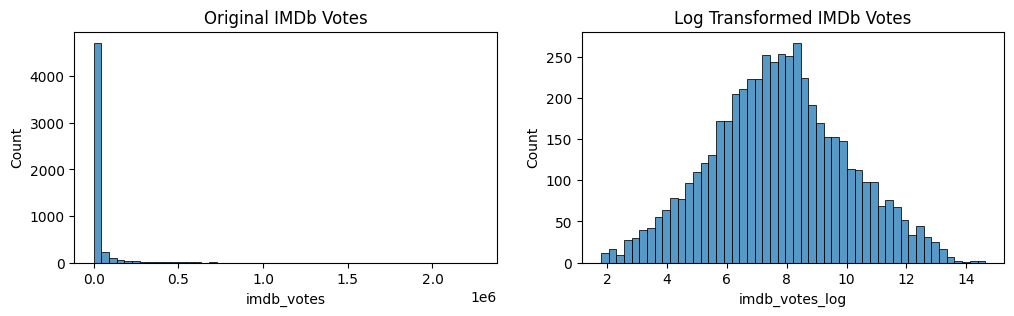

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
sns.histplot(df['imdb_votes'], bins=50)
plt.title("Original IMDb Votes")

plt.subplot(1,2,2)
sns.histplot(df['imdb_votes_log'], bins=50)
plt.title("Log Transformed IMDb Votes")

plt.show()


| Column          | Outliers Real or Error? | What You Should Do |
| --------------- | ----------------------- | ------------------ |
| runtime         | Real long movies        | Keep               |
| imdb_score      | Real ratings            | Keep               |
| imdb_votes      | Popularity effect       | Log (for ML)       |
| tmdb_popularity | Popular titles          | Keep               |
| tmdb_score      | Real ratings            | Keep               |
| seasons         | Long-running shows      | Keep               |


- Outliers were detected in multiple numerical columns using the IQR method.
- However, most extreme values represent genuine real-world variations
- such as highly popular titles, long-duration movies, and long-running TV shows.
- Therefore, these outliers were retained for analysis,
- as removing them would eliminate meaningful information.

### FEATURE RELATIONSHIP ANALYSIS
- Analyze relationships between numerical and categorical features to uncover patterns in ratings, popularity, genres, and content production trends.

#### Correlation Between Numerical Features

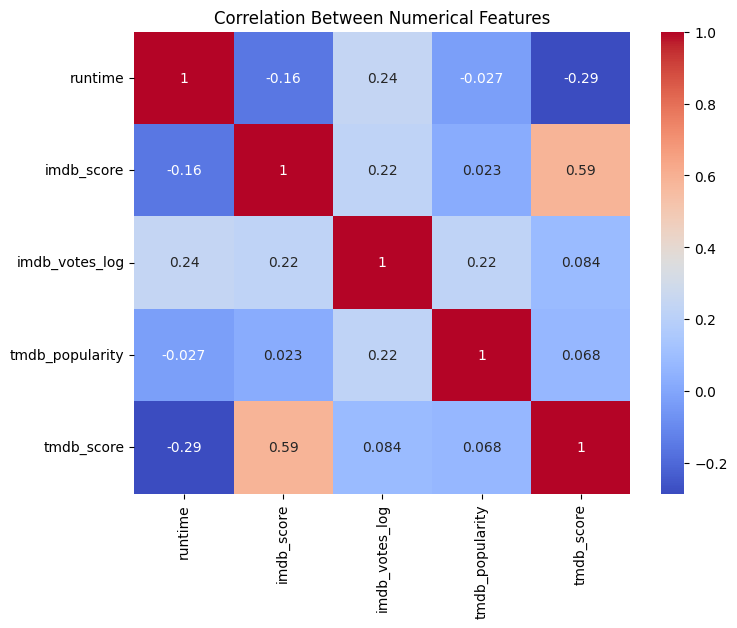

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['runtime','imdb_score','imdb_votes_log','tmdb_popularity','tmdb_score']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")
plt.show()


***IMDb votes show positive correlation with popularity.***

#### Runtime vs Ratings

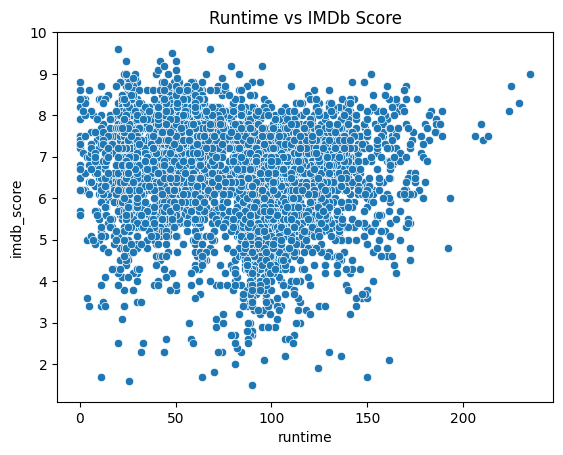

In [35]:
sns.scatterplot(x='runtime', y='imdb_score', data=df)
plt.title("Runtime vs IMDb Score")
plt.show()


#### Popularity vs Votes

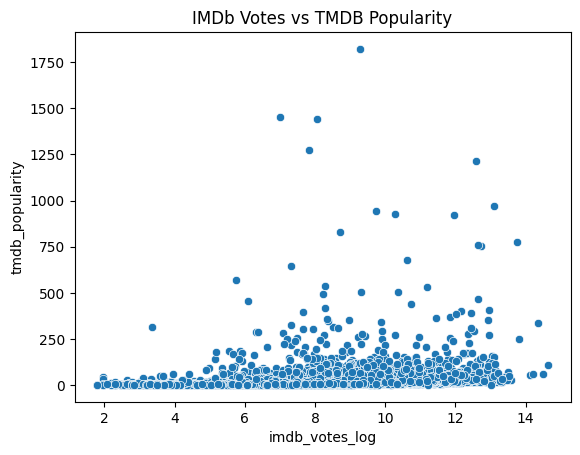

In [36]:
sns.scatterplot(x='imdb_votes_log', y='tmdb_popularity', data=df)
plt.title("IMDb Votes vs TMDB Popularity")
plt.show()


#### Genre vs Ratings (Important Insight)

In [41]:
df_genre = df.copy()
df_genre['genres'] = df_genre['genres'].str.split(',')
df_genre = df_genre.explode('genres')

df_genre = df_genre.reset_index(drop=True)  


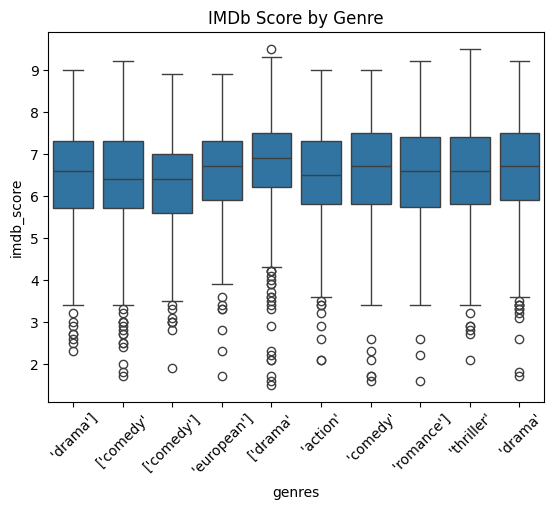

In [45]:
top_genres = df_genre['genres'].value_counts().head(10).index

sns.boxplot(
    data=df_genre[df_genre['genres'].isin(top_genres)],
    x='genres',
    y='imdb_score'
)

plt.xticks(rotation=45)
plt.title("IMDb Score by Genre")
plt.show()


#### Country vs Content Count

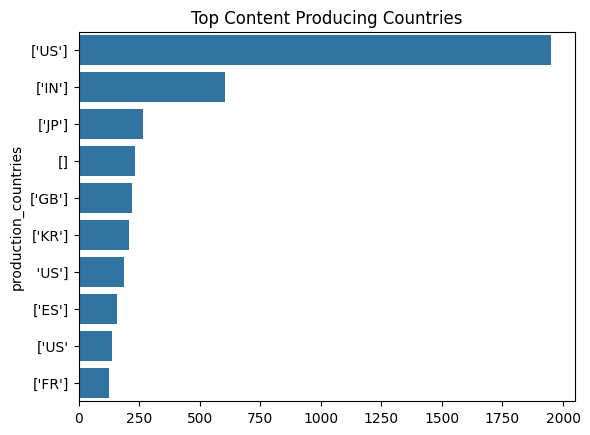

In [39]:
df_country = df.copy()
df_country['production_countries'] = df_country['production_countries'].str.split(',')
df_country = df_country.explode('production_countries')

top_countries = df_country['production_countries'].value_counts().head(10)

sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top Content Producing Countries")
plt.show()


#### learnings
- Studied relationships between ratings, votes, popularity, and runtime
- Used correlation heatmap and scatter plots to find patterns
- Learned to handle multi-genre and multi-country columns using split and explode
- Compared IMDb ratings across different genres
- Identified top content-producing countries
- Fixed duplicate index error by resetting index after explode